In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch

# Welcome to Caustics!

In this introduction, we will showcase some of the features and design principles of Caustics. We will see
1. How to get started from one of our pre-built `Simulator`

2. Visualization of the `Simulator` graph (DAG of `caustics` modules)

3. Distinction between **Static** and **Dynamic** parameters

4. How to create a a **batch** of simulations

5. Semantic structure of the Simulator input
6. Taking gradient w.r.t. to parameters with `Pytorch` autodiff functionalities
7. Swapping in flexible modules like the `Pixelated` representation for more advanced usage
8. A hint at other advanced usage like multiplane simulations

## Getting started with the `LensSource` Simulator

For this first introduction, we use the simplect modules in caustics for the lens and source, namely the `SIE` and the `Sersic` modules. We also assume a `FlatLambdaCDM` cosmology. 

In [76]:
from caustics import LensSource, SIE, Sersic, FlatLambdaCDM

# Define parameters of the camera pixel grid
pixelscale = 0.04 # arcsec/pixel
pixels = 100

# Instantiate modules for the simulator
cosmo = FlatLambdaCDM(name="cosmo")
lens = SIE(cosmology=cosmo, name="lens")
source = Sersic(name="source")
simulator = LensSource(lens, source, pixelscale=pixelscale, pixels_x=pixels)

### Generating a simulation of a strong gravitational lens

In [77]:
z_s = torch.tensor([1.0])
lens_params = torch.tensor(
    [
        0.5, # z_l
        0.0, # x_0
        0.0, # y_0
        0.9, # q
        0.4, # phi
        1.0, # b (Einstein radius)
        ]
        )

source_params = torch.tensor(
    [
        0.0, # x_0
        0.0, # y_0
        0.5, # q
        0.9, # phi
        1.0, # n
        0.1, # Re
        10.0, # I_e
        ]
        )

In [78]:
# Generate a lensed image
y = simulator([z_s, lens_params, source_params])

Text(0.5, 0, "$\\theta_x$ ['']")

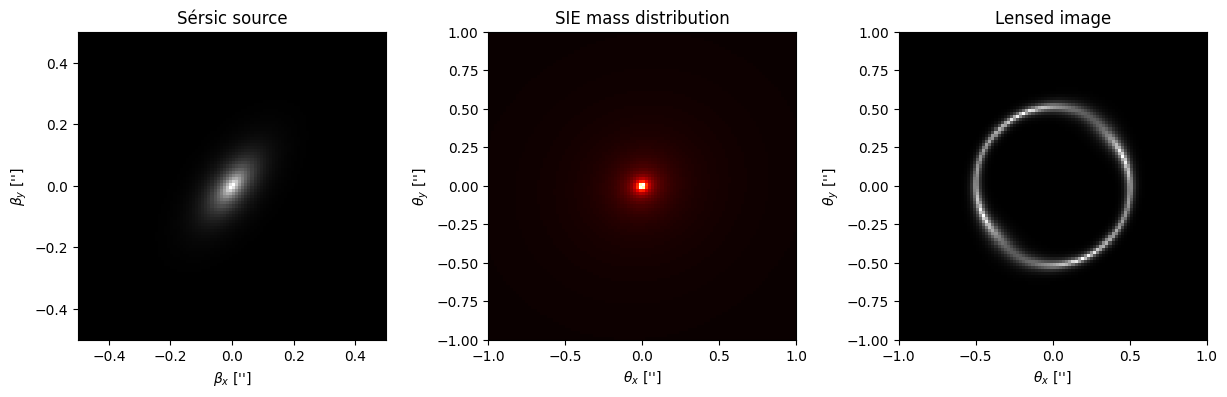

In [79]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# A meshgrid to show the source
x = torch.linspace(-0.5, 0.5, 100)
X, Y = torch.meshgrid(x, x, indexing='xy')

ax = axs[0]
ax.set_title(r"Sérsic source")
source_im = source.brightness(X, Y, source_params)
ax.imshow(source_im, origin='lower', extent=(-0.5, 0.5, -0.5, 0.5), cmap="gray")
ax.set_ylabel(r"$\beta_y$ ['']")
ax.set_xlabel(r"$\beta_x$ ['']")

ax = axs[1]
ax.set_title(r"SIE mass distribution")
lens_im = lens.convergence(X*2, Y*2, z_s, lens_params)
ax.imshow(lens_im, origin='lower', extent=(-1, 1, -1, 1), cmap="hot")
ax.set_ylabel(r"$\theta_y$ ['']")
ax.set_xlabel(r"$\theta_x$ ['']")

ax = axs[2]
ax.set_title(r"Lensed image")
ax.imshow(y, origin='lower', extent=(-1, 1, -1, 1), cmap="gray")
ax.set_ylabel(r"$\theta_y$ ['']")
ax.set_xlabel(r"$\theta_x$ ['']")

### Visualization of the `Simulator` DAG 


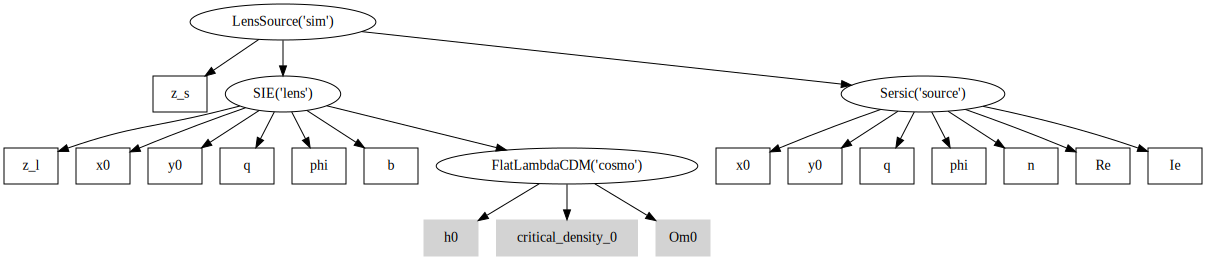

In [80]:
simulator.get_graph(True, True)

### **Static** vs **Dynamic** parameters

In the DAG shown above, 

- **Dynamic parameters** are shown with white boxes
- **Static parameters** are shown grey boxes 

The distinction is between these two types can be summarized as follows

- **Dynamic parameters** are fed as input to the simulator and can be batched over (data parallelism)
- **Static parameters** have fixed values. Their values is stored in the simulator, and will be broadcasted over batched dynamic parameters


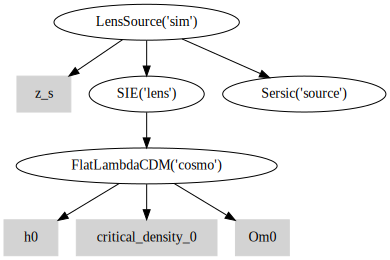

In [81]:
# Making a parameter static
simulator.z_s = 1.0 
simulator.get_graph(False, True) # z_s turns grey

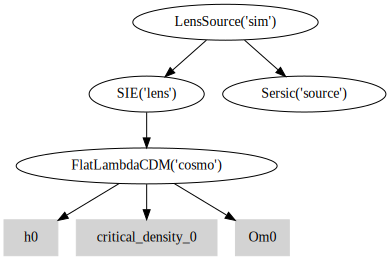

In [82]:
# Making a parameter dynamic
simulator.z_s = None
simulator.get_graph(False, True) # z_s turns white, which makes it disappear when we don't show the dynamic parameters (first option False)

### Simulating a batch of observations

We use `vmap` over the simulator to create a batch of parameters. In this example, we create a batch of examples that only differ by their Einstein radius. To do this, we turn all the other parameter into static parameters. This is done in the hidden cell below

In [83]:
# Make all parameters static except the Einstein radius
simulator.lens.x0 = 0.
simulator.lens.y0 = 0.
simulator.lens.q = 0.9
simulator.lens.phi = 0.4
simulator.lens.b = None # Make sure this one stays Dynamic
simulator.lens.z_l = 0.5

simulator.source.x0 = 0.
simulator.source.y0 = 0.
simulator.source.q = 0.5
simulator.source.phi = 0.5
simulator.source.n = 1.0
simulator.source.Re = 0.1
simulator.source.Ie = 10.0

simulator.z_s = 1.0

In [84]:
from torch import vmap

# Create a grid of Einstein radius
b = torch.linspace(0.5, 1.5, 5).view(-1, 1) # Shape is [B, 1]
ys = vmap(simulator)(b)

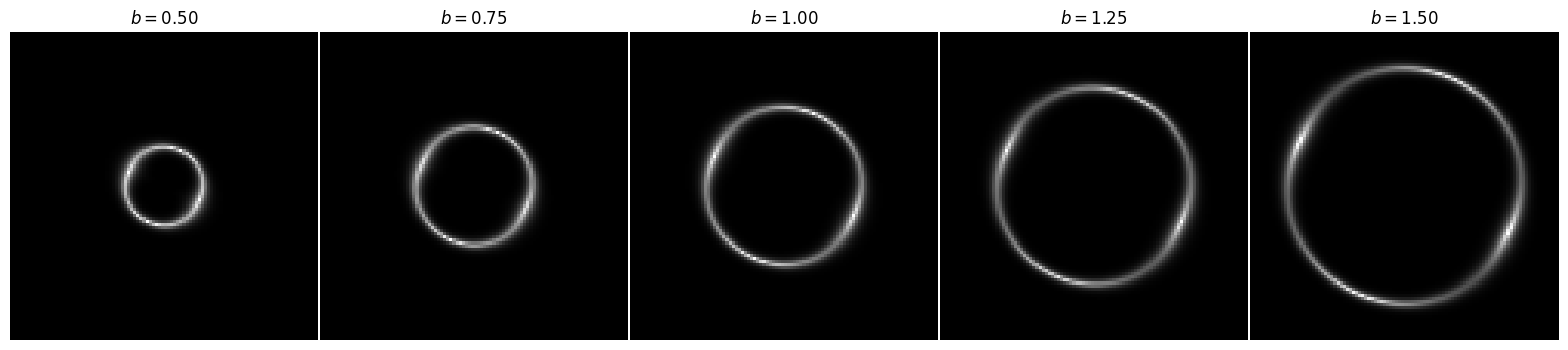

In [85]:
fig, axs = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(ys[i], cmap="gray")
    ax.set_title(f"$b = {b[i].item():.2f}$")
plt.subplots_adjust(wspace=0, hspace=0)

### Semantic structure of the input

The simulator's input takes different format to allow different usecases scenarios
1. Flattened tensor for e.g. deep neural network like in [Hezaveh et al. (2017)](https://arxiv.org/abs/1708.08842)
2. Semantic List to separate the higher level modules like Lens and Source
3. Low-level Dictionary to decompose the parameters at the level of the leafs of the DAG

Below, we illustrate how to use all of these structures, and show that `vmap` also works with these structures in case this wasn´t known. 

In [86]:
# Make some parameters dynamic for this example
simulator.source.Ie = None
simulator.lens.b = None

#### Flattened Tensor
To make sure the order of the parameter is correct, print the simulator. Order of dynamic parameters is shown in the `x_order` field

In [87]:
simulator

LensSource(
    name='sim',
    static=[z_s],
    dynamic=[],
    x_order=[lens.b, source.Ie]
)

In [88]:
b = torch.rand(5, 1)
Ie = torch.rand(5, 1)
x = torch.concat([b, Ie], dim=1) # Concat along the feature dimension

# Now we can use vmap to simulate multiple images at once
ys = vmap(simulator)(x)

#### Semantic lists

A semantic list is simply a list over module parameters like the one we used earlier: `[z_s, lens_params, source_params]`. Note that we could also include cosmological parameters in that list

In [89]:
# Make some parameters dynamic for this example
simulator.source.Ie = None
simulator.lens.b = None
simulator.lens.x0 = None
simulator.lens.cosmology.h0 = None

simulator

LensSource(
    name='sim',
    static=[z_s],
    dynamic=[],
    x_order=[lens.x0, lens.b, cosmo.h0, source.Ie]
)

In [90]:
B = 5
lens_params = torch.randn(B, 2) # x0 and b
source_params = torch.rand(B, 1) # Ie
cosmo_params = torch.rand(B, 1) # h0

# Now we can use vmap to simulate multiple images at once
x = [lens_params, cosmo_params, source_params]
ys = vmap(simulator)(x)

#### Low-level Dictionary

In [91]:
B = 5
x0 = torch.randn(B, 1)
b = torch.randn(B, 1)
Ie = torch.rand(B, 1)
h0 = torch.rand(B, 1)

# Now we can use vmap to simulate multiple images at once
x = {
    "lens": {
        "x0": x0,
        "b": b,
    },
    "source": {
        "Ie": Ie,
    },
    "cosmo": {
        "h0": h0,
    },
}
ys = vmap(simulator)(x)


## Computing gradients